In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

In [2]:
data = pd.read_csv(r"..\Dataset Preparation\FinalData.csv")
data.head()

,Exp,Folder,Mode,Frame,MeanR,VarR,MinR,Q1R,MedR,Q3R,...,VarIR,MinIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,PtsIR,Concentration
0,18_09_2024_2gSodium,01_Full,Degen,1270,0.011956,0.129460,0.0,0.0,0.0,0.0,...,1.138393,0.0,1.242808,1.196550,1.211091,1.044270,1.773443,0.983807,1.0,2030.110000
1,18_09_2024_2gSodium,01_Full,Degen,1271,0.009799,0.095385,0.0,0.0,0.0,0.0,...,1.138973,0.0,1.242930,1.196922,1.211649,1.042752,1.774462,0.980042,1.0,2022.796748
2,18_09_2024_2gSodium,01_Full,Degen,1272,0.011616,0.113608,0.0,0.0,0.0,0.0,...,1.139380,0.0,1.243419,1.196984,1.211622,1.036582,1.771977,0.982781,1.0,2015.548649
3,18_09_2024_2gSodium,01_Full,Degen,1273,0.009920,0.092299,0.0,0.0,0.0,0.0,...,1.138379,0.0,1.244232,1.196922,1.210374,1.038002,1.771729,0.985877,1.0,2008.365266
4,18_09_2024_2gSodium,01_Full,Degen,1274,0.009822,0.094579,0.0,0.0,0.0,0.0,...,1.138545,0.0,1.242483,1.197728,1.210693,1.047502,1.768001,0.984631,1.0,2001.246166


In [3]:
exp_name = list(data['Exp'].unique())

# Feature Engineering

## Feature Removal

In [220]:
insig_features = ['MinR','Q1R','MedR','Q3R','MinSig', 'PtsSig', 'MinRef','Q1Ref','MedRef','Q3Ref', 'MinIR', 'PtsIR']

In [221]:
df = data.copy()
df.drop(insig_features, axis=1, inplace=True)
features = list(df.columns)[4:-1]
target = 'Concentration'
print(len(features))

28


## Remove Outliers

- Exp0 and Exp4 outliers in IR data need to be removed

### Exp 1

In [93]:
impute_col = [col for col in features if "IR" in col] # All IR parameters column
impute_col

['MeanIR', 'VarIR', 'Q1IR', 'MedIR', 'Q3IR', 'MaxIR', 'SkewIR', 'KurtIR']

In [94]:
threshold = 1.14
row_index = df[(df['Exp'] == exp_name[0]) & (df['MeanIR'] < threshold)].index
l_ind = max(0, row_index[0] - 5)
r_ind = min(row_index[0] + 5, len(df))

In [95]:
df.loc[row_index[0], impute_col] = pd.concat([df.loc[l_ind:row_index[0]-1, impute_col], df.loc[row_index[0]+1:r_ind+1, impute_col]], axis=0).mean()

### Experiment 3

Raw length:  919
Thresholded length:  916


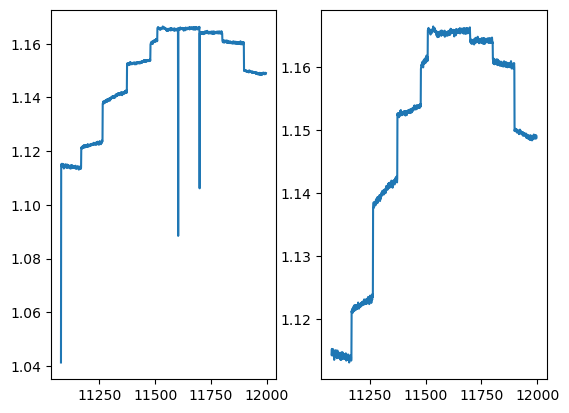

In [97]:
threshold = 1.11
plt.subplot(1,2,1)
df[(df['Exp'] == exp_name[3])]['MeanIR'].plot()
plt.subplot(1,2,2)
df[(df['Exp'] == exp_name[3]) & (df['MeanIR'] > threshold)]['MeanIR'].plot()
print("Raw length: ", len(df[(df['Exp'] == exp_name[3])]['MeanIR']))
print("Thresholded length: ", len(df[(df['Exp'] == exp_name[3]) & (df['MeanIR'] > threshold)]))

In [98]:
threshold = 1.11
exp = 3
row_index = df[(df['Exp'] == exp_name[exp]) & (df['MeanIR'] < threshold)].index
for ind in row_index:
    min_index = min(df[(df['Exp'] == exp_name[exp])].index)
    l_ind = max(min_index, ind - 5)
    r_ind = min(ind + 5, len(df))
    
    df.loc[ind, impute_col] = df.loc[ind, impute_col] = pd.concat([df[(df['Exp'] == exp_name[exp])].loc[l_ind:ind-1, impute_col], df[(df['Exp'] == exp_name[exp])].loc[ind+1:r_ind+1, impute_col]], axis=0).mean()

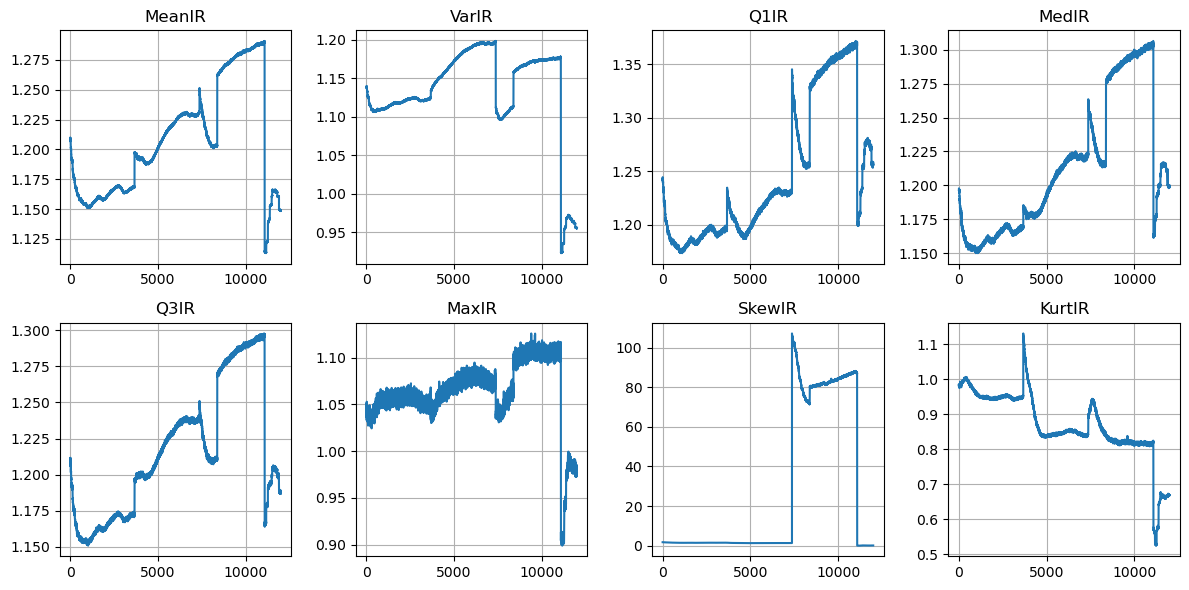

In [103]:
v_dim = 4
h_dim = math.ceil(len(impute_col) / v_dim)
fig, axes = plt.subplots(nrows=h_dim, ncols=v_dim, figsize=(12, 3 * h_dim))
for i, ax in enumerate(axes.flat):
    ax.plot(df[impute_col[i]])
    ax.set_title(impute_col[i])
    ax.grid(True)

plt.tight_layout()
plt.show()

In [127]:
df.to_csv("PreprocessedData.csv", index=False)

In [291]:
df = pd.read_csv("PreprocessedData.csv")

In [8]:
df[df['Exp'] != exp_name[3]].describe()

,Frame,MeanR,VarR,MaxR,SkewR,KurtR,PtsR,MeanSig,VarSig,Q1Sig,...,PtsRef,MeanIR,VarIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,Concentration
count,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,...,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000,11078.000000
mean,3152.610941,1.112619,1.045361,2.996542,1.854989,22.938773,1.286110,0.483326,0.442969,1.179423,...,0.788444,1.212241,1.149444,1.245469,1.213590,1.217974,1.070001,29.085622,0.889898,276.919669
std,1068.295653,0.533108,0.355570,3.821449,2.764869,122.805567,0.501304,0.173328,0.144853,0.168233,...,0.283135,0.044862,0.032000,0.066494,0.051074,0.046510,0.022355,39.152973,0.065947,368.177613
min,1250.000000,0.006696,0.081646,0.959736,0.725258,0.408787,0.011319,0.069868,0.048244,0.833333,...,0.007768,1.150860,1.095969,1.173433,1.150024,1.150919,1.024290,1.294032,0.808128,24.876361
25%,2229.250000,0.806384,0.874119,0.984457,0.972576,1.162910,1.034474,0.392540,0.356971,1.000000,...,0.692616,1.167386,1.118581,1.192516,1.167495,1.171153,1.052693,1.348139,0.836506,86.128316
50%,3152.500000,1.099225,1.029893,2.124737,1.132881,1.730981,1.402183,0.501531,0.474059,1.252900,...,0.813109,1.205471,1.158622,1.218390,1.207379,1.212100,1.064800,1.501495,0.853887,149.118215
75%,4075.750000,1.508254,1.258709,3.044867,1.404375,2.831194,1.662064,0.627135,0.560729,1.299304,...,0.980971,1.237502,1.175256,1.320039,1.252773,1.239869,1.085320,81.086442,0.947900,271.722580
max,5100.000000,2.050000,2.725902,83.266030,45.403459,2877.181787,1.968566,0.731435,0.655178,1.400000,...,1.151753,1.290754,1.198708,1.371713,1.306428,1.297677,1.125834,107.141990,1.131007,2030.110000


# Modeling

In [292]:
#Take only first 3 experiments
X = df[df['Exp'] != exp_name[3]][features]
y = df[df['Exp'] != exp_name[3]][target]

In [293]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=102)

In [294]:
## Scaling
scaler = RobustScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

In [295]:
def performance(ytest, ypred, model_type):
    rmse = np.sqrt(mean_squared_error(ytest, ypred))
    mae = mean_absolute_error(ytest, ypred)
    mape = mean_absolute_percentage_error(ytest, ypred)
    r2 = r2_score(ytest, ypred)
    return [model_type, mae, mape, rmse, r2]

## Linear Regression

In [296]:
test_res = []
train_res = []
feature_score = []
lir = LinearRegression()
lir.fit(xtrain_scaled, ytrain)
ypred = lir.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'Linear'))
train_res.append(performance(ytrain, lir.predict(xtrain_scaled), 'Linear'))
feature_score.append(lir.coef_)

# Polynomial Regression

In [297]:
from sklearn.preprocessing import PolynomialFeatures

In [298]:
poly = PolynomialFeatures(degree=2)  # Change degree for higher polynomial
X_poly = poly.fit_transform(xtrain_scaled)

In [299]:
poly_model = LinearRegression()
poly_model.fit(X_poly, ytrain)
ypred = poly_model.predict(poly.transform(xtest_scaled))
test_res.append(performance(ytest, ypred, 'Polynomial'))
train_res.append(performance(ytrain, poly_model.predict(X_poly), 'Polynomial'))
#feature_score.append(rfm.feature_importances_)

## Decision Tree

In [300]:
dt = DecisionTreeRegressor(random_state=102)
dt.fit(xtrain_scaled, ytrain)
ypred = dt.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'DT'))
train_res.append(performance(ytrain, dt.predict(xtrain_scaled), 'DT'))
feature_score.append(dt.feature_importances_)

## Random Forest

In [301]:
rfm = RandomForestRegressor(random_state=102)
rfm.fit(xtrain, ytrain)
ypred = rfm.predict(xtest)
test_res.append(performance(ytest, ypred, 'Random Forest'))
train_res.append(performance(ytrain, rfm.predict(xtrain), 'Random Forest'))
feature_score.append(rfm.feature_importances_)

In [275]:
feature_score = [(features[i], rfm.feature_importances_[i]) for i in range(len(features))]
feature_score = sorted(feature_score, key = lambda x: x[1], reverse=True)
ordered_features = [ele[0] for ele in feature_score]

## Feature Importance

In [289]:
feature_score = [(feature_names[i], -1/np.log(rfm.feature_importances_[i])) for i in range(len(features))]
feature_score = sorted(feature_score, key = lambda x: x[1], reverse=True)
feature_score

[('Points Range', 3.2326526176609187),
 ('Mean Range', 0.44153003040627564),
 ('Points Reflect', 0.3891956702096075),
 ('Kurt IR', 0.2835650116785548),
 ('Mean Signal', 0.23923797275828831),
 ('Skew IR', 0.2305149086992385),
 ('Variance Reflect', 0.19171741064415943),
 ('Median Signal', 0.18774131026670748),
 ('Variance Signal', 0.18363288888627405),
 ('Mean IR', 0.1743067929237926),
 ('Mean Reflect', 0.16920460058639505),
 ('Q3 IR', 0.15741687162679807),
 ('Q1 IR', 0.15264177697278125),
 ('Median IR', 0.14905299724233737),
 ('Q1 Signal', 0.13538020553408667),
 ('Variance IR', 0.13500010230246748),
 ('Max Signal', 0.13259547270270136),
 ('Skew Signal', 0.12435318339514882),
 ('Skew Reflect', 0.1181297768974608),
 ('Kurt Reflect', 0.11778023158823847),
 ('Kurt Signal', 0.11120334909544),
 ('Max Reflect', 0.108558720542057),
 ('Q3 Signal', 0.10359963596776511),
 ('Variance Range', 0.10313424277741425),
 ('Skew Range', 0.10046549353872218),
 ('Kurt Range', 0.09610029416430536),
 ('Max Ran

In [288]:
feature_names = ['Mean Range', 'Variance Range', 'Max Range', 'Skew Range', 'Kurt Range', 'Points Range', 'Mean Signal', 'Variance Signal', 'Q1 Signal', 'Median Signal', 'Q3 Signal', 'Max Signal', 'Skew Signal', 'Kurt Signal', 'Mean Reflect', 'Variance Reflect', 'Max Reflect', 'Skew Reflect', 'Kurt Reflect', 'Points Reflect', 'Mean IR', 'Variance IR', 'Q1 IR', 'Median IR', 'Q3 IR', 'Max IR', 'Skew IR', 'Kurt IR']
len(feature_names)

28

<Axes: >

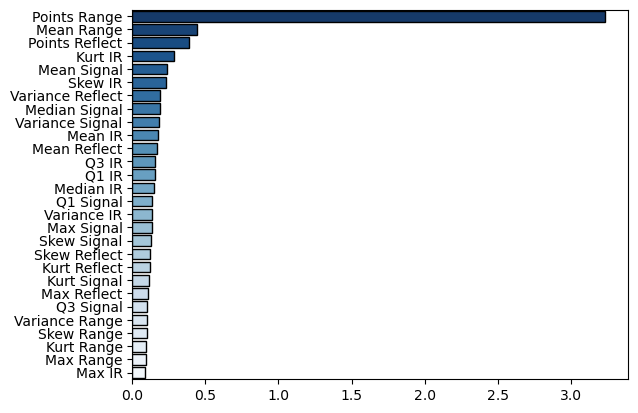

In [290]:
feats = [i[0] for i in feature_score]
scores = [i[1] for i in feature_score]
sns.barplot(x=scores, y=feats, palette="Blues_r", edgecolor="black")

In [234]:
test_res = []
for i in range(1, len(ordered_features)+1):
    features_in = ordered_features[:i]
    rfm_model = RandomForestRegressor(random_state=102)
    rfm_model.fit(xtrain.loc[:, features_in], ytrain)
    ypred = rfm_model.predict(xtest.loc[:, features_in])
    test_res.append(performance(ytest, ypred, 'Random Forest'))
    print("Model " + str(i) + " Completed")
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

Model 1 Completed
Model 2 Completed
Model 3 Completed
Model 4 Completed
Model 5 Completed
Model 6 Completed
Model 7 Completed
Model 8 Completed
Model 9 Completed
Model 10 Completed
Model 11 Completed
Model 12 Completed
Model 13 Completed
Model 14 Completed
Model 15 Completed
Model 16 Completed
Model 17 Completed
Model 18 Completed
Model 19 Completed
Model 20 Completed
Model 21 Completed
Model 22 Completed
Model 23 Completed
Model 24 Completed
Model 25 Completed
Model 26 Completed
Model 27 Completed
Model 28 Completed


,Model,MAE,MAPE,RMSE,R2 Score
0,Random Forest,38.209557,0.272612,67.672199,0.965729
1,Random Forest,22.319054,0.143701,51.268912,0.980329
2,Random Forest,11.240809,0.075646,26.535679,0.994730
3,Random Forest,7.137961,0.065671,13.385208,0.998659
4,Random Forest,2.678469,0.014270,6.671572,0.999667
5,Random Forest,2.476415,0.013895,5.839372,0.999745
6,Random Forest,2.168354,0.012117,5.593480,0.999766
7,Random Forest,2.134743,0.012003,5.599105,0.999765
8,Random Forest,2.030578,0.010945,5.526380,0.999771
9,Random Forest,2.089847,0.011124,5.421788,0.999780


## GBDT

In [302]:
gbr = GradientBoostingRegressor(random_state=102)
gbr.fit(xtrain_scaled, ytrain)
ypred = gbr.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'GBDT'))
train_res.append(performance(ytrain, gbr.predict(xtrain_scaled), 'GBDT'))
feature_score.append(gbr.feature_importances_)

# SVR

In [303]:
svr = SVR()
svr.fit(xtrain_scaled, ytrain)
ypred = svr.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'SVR'))
train_res.append(performance(ytrain, svr.predict(xtrain_scaled), 'SVR'))
# feature_score.append(svr.feature_importances_)

# SVR Linear

In [304]:
svr_poly = SVR(kernel='linear', degree=3)
svr_poly.fit(xtrain_scaled, ytrain)
ypred = svr_poly.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'SVR Linear'))
train_res.append(performance(ytrain, svr_poly.predict(xtrain_scaled), 'SVR'))

# KNN

In [305]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(xtrain_scaled, ytrain)
ypred = knn.predict(xtest_scaled)
test_res.append(performance(ytest, ypred, 'KNN'))
train_res.append(performance(ytrain, knn.predict(xtrain_scaled), 'KNN'))
# feature_score.append(gbr.feature_importances_)

In [306]:
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Linear,47.887973,0.398888,63.185906,0.970122
1,Polynomial,9.423017,0.072192,14.940794,0.998329
2,DT,3.063168,0.015774,8.189989,0.999498
3,Random Forest,1.988695,0.010237,4.904418,0.999820
4,GBDT,8.969959,0.066059,13.317952,0.998673
5,SVR,174.052983,0.903435,334.314577,0.163582
6,SVR Linear,63.730978,0.441115,95.283234,0.932057
7,KNN,11.401396,0.073005,40.450508,0.987755


In [308]:
pd.DataFrame(train_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Linear,48.602111,0.409973,63.844256,0.970108
1,Polynomial,8.403750,0.067266,12.380424,0.998876
2,DT,0.000000,0.000000,0.000000,1.000000
3,Random Forest,0.729781,0.003934,1.917874,0.999973
4,GBDT,7.754793,0.061413,11.211356,0.999078
5,SVR,177.166451,0.926627,337.665192,0.163862
6,SVR,65.729248,0.448311,100.303089,0.926221
7,KNN,9.796730,0.060748,34.223862,0.991411


In [88]:
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Linear,47.887973,0.398888,63.185906,0.970122
1,DT,3.063168,0.015774,8.189989,0.999498
2,Random Forest,1.988987,0.010150,4.907132,0.999820
3,GBDT,8.969959,0.066059,13.317952,0.998673
4,SVR,174.052983,0.903435,334.314577,0.163582
5,KNN,11.401396,0.073005,40.450508,0.987755


## Feature Importance Score

In [44]:
lir.feature_names_in_

array(['MeanR', 'VarR', 'MaxR', 'SkewR', 'KurtR', 'PtsR', 'MeanSig',
       'VarSig', 'Q1Sig', 'MedSig', 'Q3Sig', 'MaxSig', 'SkewSig',
       'KurtSig', 'MeanRef', 'VarRef', 'MaxRef', 'SkewRef', 'KurtRef',
       'PtsRef', 'MeanIR', 'VarIR', 'Q1IR', 'MedIR', 'Q3IR', 'MaxIR',
       'SkewIR', 'KurtIR'], dtype=object)

In [60]:
feature_scores = [list(score) for score in feature_score]
df_scores = pd.DataFrame(feature_scores, columns = list(lir.feature_names_in_))
df_scores.head()

,MeanR,VarR,MaxR,SkewR,KurtR,PtsR,MeanSig,VarSig,Q1Sig,MedSig,...,KurtRef,PtsRef,MeanIR,VarIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR
0,708.709164,-3.722006e+02,0.760676,9.486958,-0.068789,-1224.689584,-927.370776,1901.186710,-1597.692254,-7.685153e+02,...,-16.614834,-172.176808,-15609.093146,7003.817595,-9904.398540,6447.389795,13554.919971,-8.957412e+02,13.347151,2746.096474
1,0.000820,2.174439e-04,0.000003,0.000091,0.000020,0.835135,0.016532,0.002063,0.000143,1.885802e-07,...,0.000075,0.072877,0.003916,0.000259,0.000547,0.000044,0.001908,2.428373e-06,0.015377,0.041509
2,0.103845,6.152293e-05,0.000016,0.000048,0.000030,0.733929,0.015299,0.004315,0.000619,4.861160e-03,...,0.000205,0.076581,0.003224,0.000607,0.001428,0.001220,0.001742,6.683633e-06,0.013061,0.029407
3,0.092394,6.646594e-07,0.000017,0.000015,0.000022,0.549484,0.012925,0.001035,0.000678,7.457969e-03,...,0.000049,0.256041,0.004963,0.000484,0.003363,0.000977,0.005307,3.045474e-07,0.007531,0.022490


<Axes: >

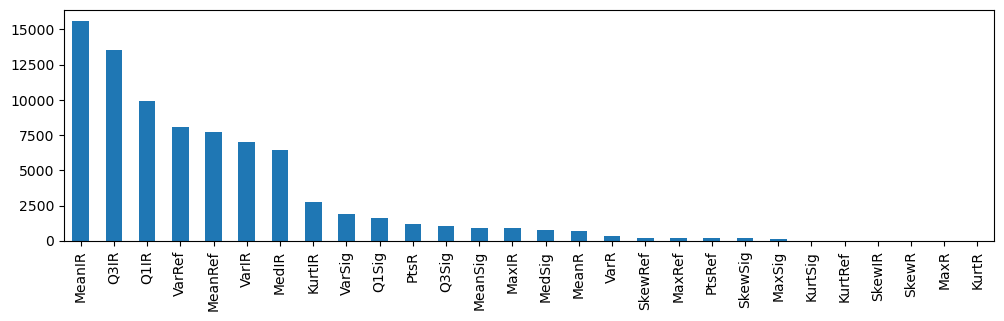

In [68]:
plt.figure(figsize=(12,3))
df_scores.loc[0].abs().sort_values(ascending=False).plot(kind='bar')
plt.title("Linear Regression Co effiecients (Absolute)")

Text(0.5, 1.0, 'Decision Tree Feature Importance Score')

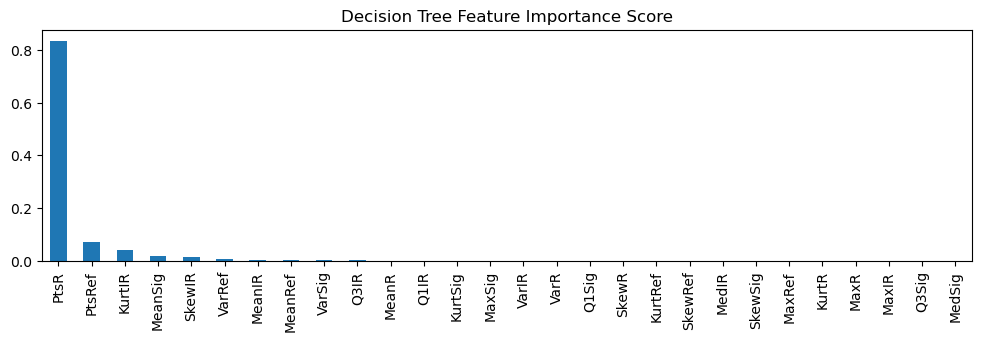

In [69]:
plt.figure(figsize=(12,3))
df_scores.loc[1].abs().sort_values(ascending=False).plot(kind='bar')
plt.title("Decision Tree Feature Importance Score")

Text(0.5, 1.0, 'Random Forest Feature Importance Score')

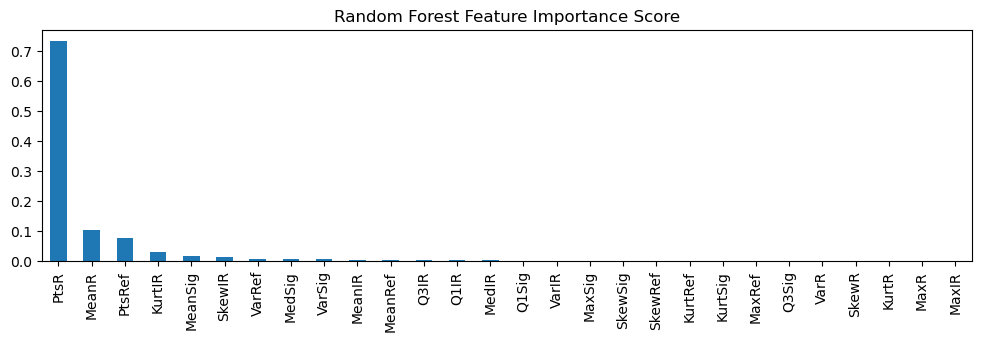

In [70]:
plt.figure(figsize=(12,3))
df_scores.loc[2].abs().sort_values(ascending=False).plot(kind='bar')

plt.title("Random Forest Feature Importance Score")

In [95]:
df_scores.loc[2].sort_values(ascending=False)

1.0

In [90]:
feature_names = ['Mean Range', 'Variance Range', 'Min Range', 'Q1 Range', 'Median Range', 'Q3 Range', 'Max Range', 'Skew Range', 'Kurt Range', 'Points Range', 'Mean Signal', 'Variance Signal', 'Min Signal', 'Q1 Signal', 'Median Signal', 'Q3 Signal', 'Max Signal', 'Skew Signal', 'Kurt Signal', 'Points Signal', 'Mean Reflect', 'Variance Reflect', 'Min Reflect', 'Q1 Reflect', 'Median Reflect', 'Q3 Reflect', 'Max Reflect', 'Skew Reflect', 'Kurt Reflect', 'Points Reflect', 'Mean IR', 'Variance IR', 'Min IR', 'Q1 IR', 'Median IR', 'Q3 IR', 'Max IR', 'Skew IR', 'Kurt IR', 'Points IR']

Text(0.5, 1.0, 'GBDT Feature Importance Score')

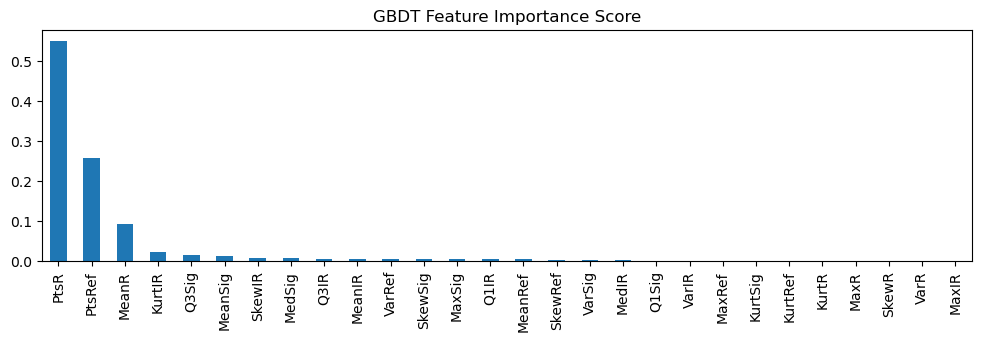

In [71]:
plt.figure(figsize=(12,3))
df_scores.loc[3].abs().sort_values(ascending=False).plot(kind='bar')
plt.title("GBDT Feature Importance Score")

In [56]:
# for score in feature_score:
score = feature_score[0]
maxval = np.max(score)
minval = np.min(score)
print(list(np.round((score - minval)/(maxval - minval),3)))
print(list(np.round((score - np.mean(score))/(np.std(score)),3)))

print(maxval, minval)


[0.56, 0.522, 0.535, 0.536, 0.535, 0.493, 0.503, 0.6, 0.48, 0.509, 0.57, 0.538, 0.53, 0.536, 0.8, 0.258, 0.542, 0.543, 0.535, 0.529, 0.0, 0.775, 0.196, 0.756, 1.0, 0.505, 0.536, 0.629]
[0.123, -0.085, -0.013, -0.011, -0.013, -0.248, -0.191, 0.352, -0.32, -0.161, 0.183, 0.005, -0.044, -0.009, 1.468, -1.567, 0.024, 0.031, -0.016, -0.046, -3.008, 1.331, -1.914, 1.224, 2.588, -0.185, -0.011, 0.514]
13554.919970762961 -15609.093145933635


,MeanR,VarR,MaxR,SkewR,KurtR,PtsR,MeanSig,VarSig,Q1Sig,MedSig,...,MeanIR,VarIR,Q1IR,MedIR,Q3IR,MaxIR,SkewIR,KurtIR,max,min
0,708.709164,-3.722006e+02,0.760676,9.486958,-0.068789,-1224.689584,-927.370776,1901.186710,-1597.692254,-7.685153e+02,...,-15609.093146,7003.817595,-9904.398540,6447.389795,13554.919971,-8.957412e+02,13.347151,2746.096474,13554.919971,-1.560909e+04
1,0.000820,2.174439e-04,0.000003,0.000091,0.000020,0.835135,0.016532,0.002063,0.000143,1.885802e-07,...,0.003916,0.000259,0.000547,0.000044,0.001908,2.428373e-06,0.015377,0.041509,0.835135,1.885802e-07
2,0.103845,6.152293e-05,0.000016,0.000048,0.000030,0.733929,0.015299,0.004315,0.000619,4.861160e-03,...,0.003224,0.000607,0.001428,0.001220,0.001742,6.683633e-06,0.013061,0.029407,0.733929,6.683633e-06
3,0.092394,6.646594e-07,0.000017,0.000015,0.000022,0.549484,0.012925,0.001035,0.000678,7.457969e-03,...,0.004963,0.000484,0.003363,0.000977,0.005307,3.045474e-07,0.007531,0.022490,0.549484,3.045474e-07


In [55]:
score

array([ 7.08709164e+02, -3.72200569e+02,  7.60676000e-01,  9.48695793e+00,
       -6.87887635e-02, -1.22468958e+03, -9.27370776e+02,  1.90118671e+03,
       -1.59769225e+03, -7.68515292e+02,  1.01999851e+03,  9.35061080e+01,
       -1.62492518e+02,  1.95947179e+01,  7.71880464e+03, -8.09760144e+03,
        1.94849600e+02,  2.29631403e+02, -1.66148341e+01, -1.72176808e+02,
       -1.56090931e+04,  7.00381760e+03, -9.90439854e+03,  6.44738980e+03,
        1.35549200e+04, -8.95741198e+02,  1.33471506e+01,  2.74609647e+03])

In [41]:
feature_scores

[('MeanR', 708.7091635076733),
 ('VarR', -372.20056921128304),
 ('MaxR', 0.7606760001693846),
 ('SkewR', 9.486957930805817),
 ('KurtR', -0.0687887635180573),
 ('PtsR', -1224.689583773934),
 ('MeanSig', -927.3707764358015),
 ('VarSig', 1901.1867099643387),
 ('Q1Sig', -1597.6922538387594),
 ('MedSig', -768.5152920030148),
 ('Q3Sig', 1019.9985102623251),
 ('MaxSig', 93.50610804135229),
 ('SkewSig', -162.49251813844361),
 ('KurtSig', 19.594717903134367),
 ('MeanRef', 7718.804639607571),
 ('VarRef', -8097.601443428538),
 ('MaxRef', 194.84960002990198),
 ('SkewRef', 229.63140270237264),
 ('KurtRef', -16.6148340715946),
 ('PtsRef', -172.1768079434499),
 ('MeanIR', -15609.093145933635),
 ('VarIR', 7003.817595155396),
 ('Q1IR', -9904.398540178317),
 ('MedIR', 6447.389795158912),
 ('Q3IR', 13554.919970762961),
 ('MaxIR', -895.7411977677808),
 ('SkewIR', 13.347150550556364),
 ('KurtIR', 2746.096473601758),
 ('MeanR', 0.0008201792246480649),
 ('VarR', 0.00021744386804833013),
 ('MaxR', 3.016572726

# Residual Plot

<Axes: xlabel='Concentration', ylabel='Concentration'>

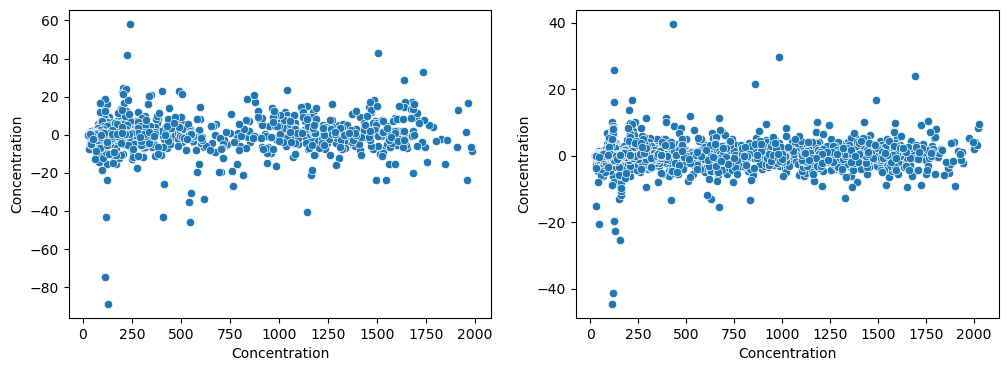

In [107]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ypred = rfm.predict(xtest_scaled)
sns.scatterplot(x=ytest, y=ytest-ypred)
plt.subplot(1,2,2)
ypred = rfm.predict(xtrain_scaled)
sns.scatterplot(x=ytrain, y=ytrain-ypred)

Text(0, 0.5, 'Residuals')

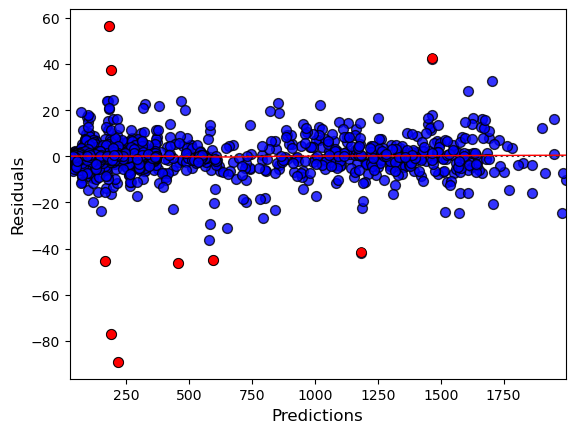

In [271]:
resid = ytest-ypred
ind = list((np.where(abs(resid) > 36)[0]))
sns.residplot(x=ypred, y=resid, lowess=True, color="b", 
              line_kws={'color': 'r', 'lw': 1}, scatter_kws={'s': 50, 'edgecolor': 'black'})
sns.scatterplot(x=ypred[ind], y=resid.iloc[ind], color="r", s= 50, edgecolor = 'black')
# plt.title("Residual Plot for Total Bill vs Tip", fontsize=16)
plt.xlabel("Predictions", fontsize=12)
plt.ylabel("Residuals", fontsize=12)

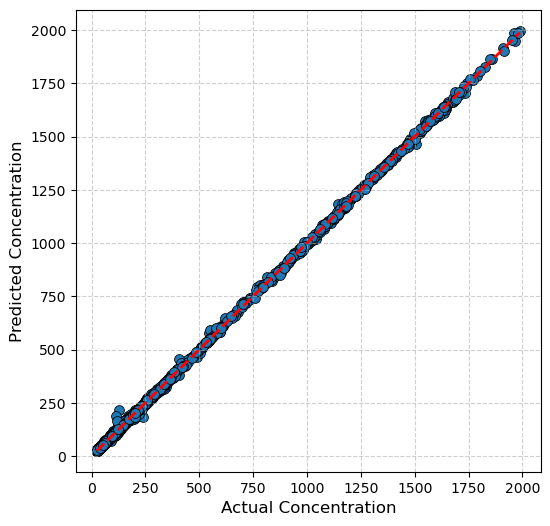

In [255]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=ytest, y=ypred, edgecolor='black', s=50)

# Plot the y = x line for reference
plt.plot([min(ytest), max(ytest)], [min(ytest), max(ytest)], color='red', linestyle='--', lw=2)

# Labels and title
plt.xlabel("Actual Concentration", fontsize=12)
plt.ylabel("Predicted Concentration", fontsize=12)
# plt.title("Actual vs. Predicted Plot", fontsize=14)

# Grid and display
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


<Axes: xlabel='Concentration', ylabel='Concentration'>

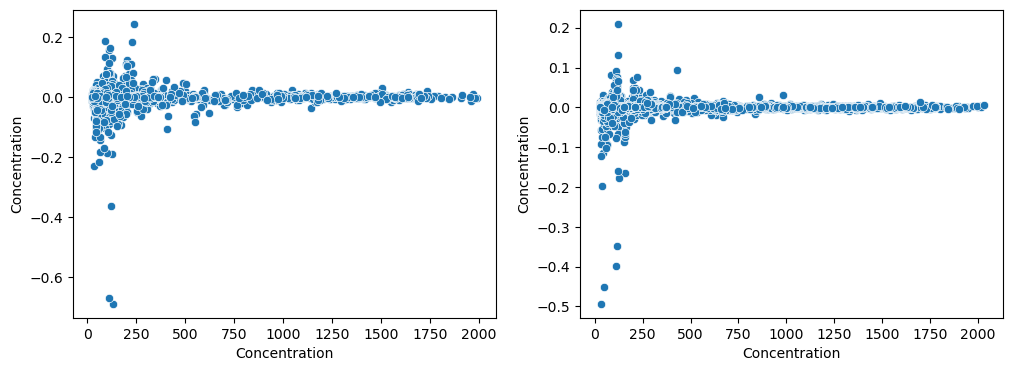

In [138]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
ypred = rfm.predict(xtest_scaled)
sns.scatterplot(x=ytest, y=(ytest-ypred)/ytest)
plt.subplot(1,2,2)
ypred = rfm.predict(xtrain_scaled)
sns.scatterplot(x=ytrain, y=(ytrain-ypred)/ytrain)

In [119]:
imp_features = ['PtsR', 'MeanR', 'PtsRef', 'KurtIR', 'MeanSig', 'SkewIR']

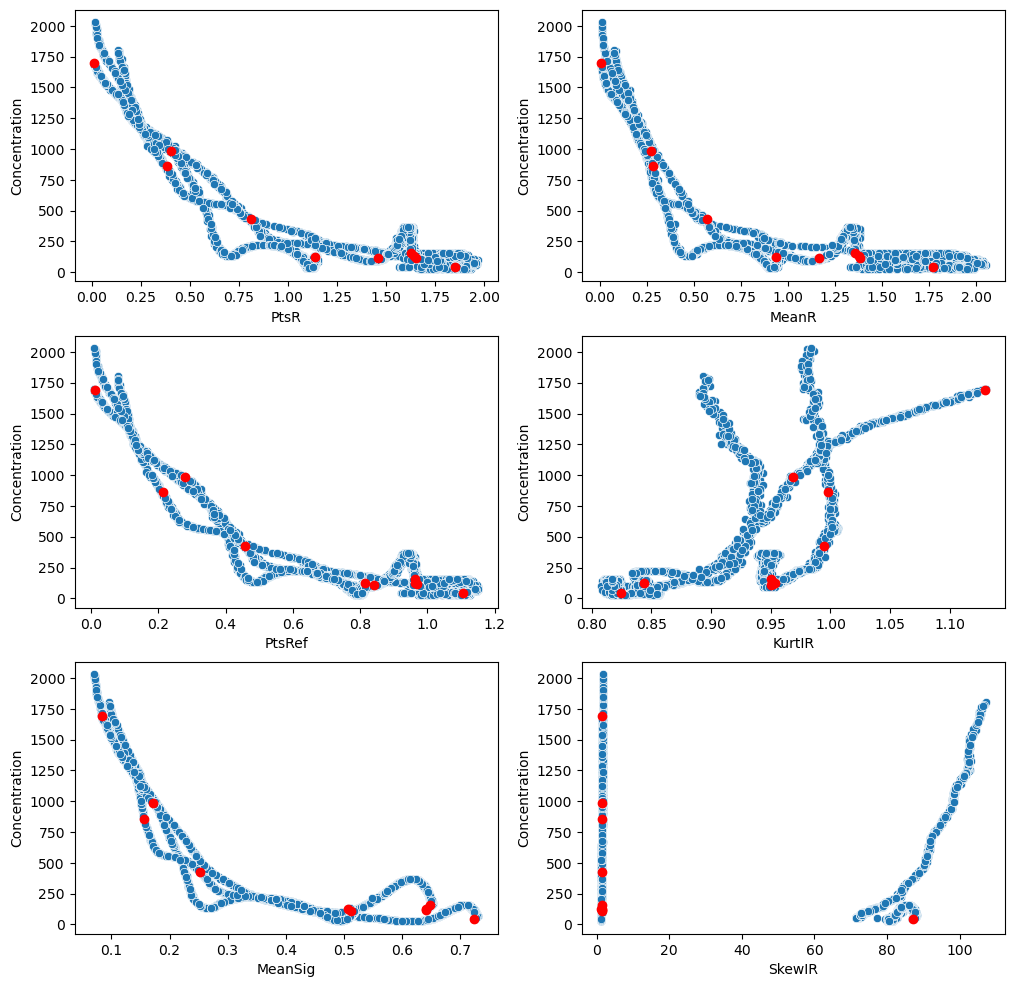

In [129]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    sns.scatterplot(x=xtrain[imp_features[i]], y=ytrain, ax=ax)
    temp=xtrain.iloc[list(np.where(abs(ypred-ytrain)>20)[0])]
    ax.plot(temp[imp_features[i]], ytrain.iloc[list(np.where(abs(ypred-ytrain)>20)[0])], marker='o', color='r', linestyle='None')

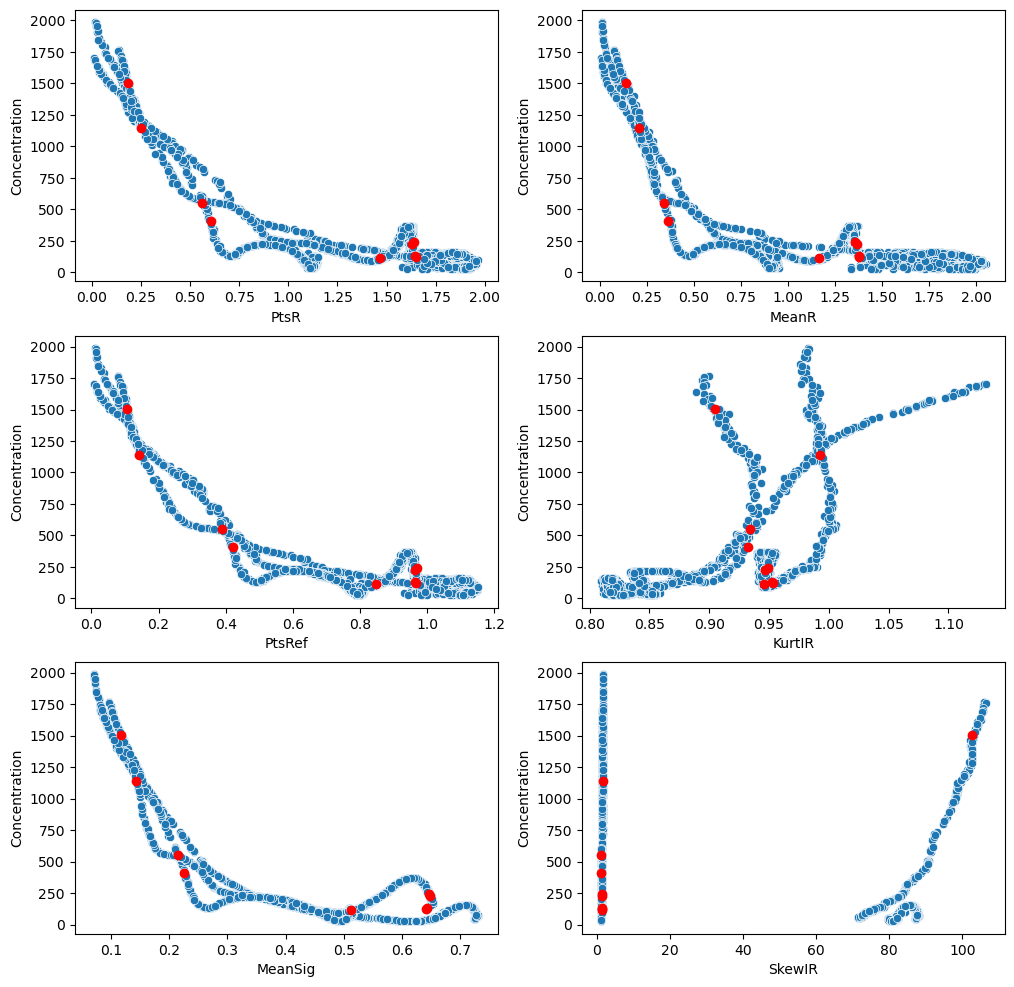

In [131]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
ypred = rfm.predict(xtest_scaled)
for i, ax in enumerate(axes.flat):
    sns.scatterplot(x=xtest[imp_features[i]], y=ytest, ax=ax)
    temp=xtest.iloc[list(np.where(abs(ypred-ytest)>40)[0])]
    ax.plot(temp[imp_features[i]], ytest.iloc[list(np.where(abs(ypred-ytest)>40)[0])], marker='o', color='r', linestyle='None')

# Hyperparameter Tuning - Random Forest

In [139]:
ypred = rfm.predict(xtest_scaled)
np.mean((ytest-ypred)/ytest)

-0.0012080806147128232

In [142]:
param = {'n_estimators':[50, 75, 100, 150, 200],
        'max_depth': [5, 10, 15, 20],
         'min_samples_split': [1,5,10],
         'min_samples_leaf': [1,5,10]}
rfm_hyp = RandomForestRegressor(random_state=102)
hyp_res = RandomizedSearchCV(rfm_hyp, param_distributions = param, cv=5)
hyp_res.fit(xtrain, ytrain)

C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\Users\ADMIN\anaconda3\Lib\site-packages\sklearn\base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ADMIN\anaconda3\Lib\site-package

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=102),
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [1, 5, 10],
                                        'n_estimators': [50, 75, 100, 150,
                                                         200]})

In [144]:
hyp_res.cv_results_

{'mean_fit_time': array([6.22589111e-02, 2.00304985e-03, 1.25959557e+01, 1.77253912e+01,
        1.04506149e+01, 2.50287757e+01, 2.02841759e-03, 2.77243648e+01,
        2.40101814e-03, 9.36263418e+00]),
 'std_fit_time': array([1.15515253e-01, 6.32595976e-07, 3.11904763e-01, 2.19441631e-01,
        2.58398410e-01, 3.77734956e-01, 2.31751689e-05, 8.91471726e-01,
        4.89285315e-04, 2.84866700e-01]),
 'mean_score_time': array([0.        , 0.        , 0.05043392, 0.049617  , 0.06065469,
        0.05306754, 0.        , 0.06464996, 0.        , 0.02622519]),
 'std_score_time': array([0.        , 0.        , 0.02252069, 0.0050087 , 0.06576361,
        0.00156204, 0.        , 0.00876476, 0.        , 0.00500744]),
 'param_n_estimators': masked_array(data=[150, 50, 75, 100, 150, 200, 100, 200, 150, 75],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': m

In [146]:

best_rfm = RandomForestRegressor(n_estimators = 100, min_samples_split= 5, min_samples_leaf= 1, max_depth =20)
best_rfm.fit(xtrain, ytrain)
ypred = best_rfm.predict(xtest)
test_res.append(performance(ytest, ypred, 'Random Forest'))
train_res.append(performance(ytrain, best_rfm.predict(xtrain), 'Random Forest'))
feature_score.append(rfm.feature_importances_)

In [147]:
pd.DataFrame(train_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Linear,48.602111,0.409973,63.844256,0.970108
1,DT,0.000000,0.000000,0.000000,1.000000
2,Random Forest,0.726336,0.003918,1.889154,0.999974
3,GBDT,7.754793,0.061413,11.211356,0.999078
4,SVR,177.166451,0.926627,337.665192,0.163862
5,KNN,9.796730,0.060748,34.223862,0.991411
6,Random Forest,0.852460,0.004478,2.113745,0.999967
7,Random Forest,0.881160,0.004629,2.244047,0.999963


In [148]:
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Linear,47.887973,0.398888,63.185906,0.970122
1,DT,3.063168,0.015774,8.189989,0.999498
2,Random Forest,1.988987,0.010150,4.907132,0.999820
3,GBDT,8.969959,0.066059,13.317952,0.998673
4,SVR,174.052983,0.903435,334.314577,0.163582
5,KNN,11.401396,0.073005,40.450508,0.987755
6,Random Forest,2.092577,0.010443,5.192612,0.999798
7,Random Forest,2.086227,0.010552,5.212136,0.999797


In [151]:
rfm = RandomForestRegressor(random_state=102)
scores = cross_val_score(rfm, xtrain, ytrain, scoring='neg_root_mean_squared_error', n_jobs=-1)

In [153]:
scores.mean()

-5.308549490532726

In [193]:
test_features = ['MeanSig', 'VarSig', 'MeanRef', 'VarRef', 'SkewRef', 'KurtRef', 'SkewSig', 'KurtSig', 'PtsR', 'MeanR']

In [200]:
#Take only first 3 experiments
X = df[df['Exp'] != exp_name[3]][features]
y = df[df['Exp'] != exp_name[3]][target]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=102)
## Scaling
scaler = RobustScaler()
xtrain_scaled = scaler.fit_transform(xtrain)
xtest_scaled = scaler.transform(xtest)

In [195]:
rfm_model = RandomForestRegressor(random_state=102)
rfm_model.fit(xtrain, ytrain)
ypred = rfm_model.predict(xtest)
test_res.append(performance(ytest, ypred, 'Random Forest'))
train_res.append(performance(ytrain, rfm_model.predict(xtrain), 'Random Forest'))
feature_score.append(rfm_model.feature_importances_)
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

,Model,MAE,MAPE,RMSE,R2 Score
0,Random Forest,2.510954,0.011349,7.757438,0.999550
1,Random Forest,2.393826,0.011115,6.582118,0.999676
2,Random Forest,2.400283,0.011186,6.546605,0.999679
3,Random Forest,2.280923,0.011333,6.200294,0.999712
4,Random Forest,2.284339,0.011042,6.421993,0.999691


In [236]:
test_res = []
n = len(features)
inc_features = []
prev_result = []
for i in range(n):
    inc_features.append(features[i])
    features_in = inc_features
    rfm_model = RandomForestRegressor(random_state=102)
    rfm_model.fit(xtrain.loc[:, features_in], ytrain)
    ypred = rfm_model.predict(xtest.loc[:, features_in])
    result = performance(ytest, ypred, 'Random Forest')
    test_res.append(result)
    if i>0 and result[3] <= prev_result[3]:
        inc_features.remove(features[i])
    prev_result = result        
    print("Model " + str(i) + " Completed")
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

Model 0Completed
Model 1Completed
Model 2Completed
Model 3Completed
Model 4Completed
Model 5Completed
Model 6Completed
Model 7Completed
Model 8Completed
Model 9Completed
Model 10Completed
Model 11Completed
Model 12Completed
Model 13Completed
Model 14Completed
Model 15Completed
Model 16Completed
Model 17Completed
Model 18Completed
Model 19Completed
Model 20Completed
Model 21Completed
Model 22Completed
Model 23Completed
Model 24Completed
Model 25Completed
Model 26Completed
Model 27Completed


,Model,MAE,MAPE,RMSE,R2 Score
0,Random Forest,39.594899,0.272114,72.496626,0.960668
1,Random Forest,20.486097,0.121499,44.857222,0.984942
2,Random Forest,19.811884,0.169859,41.472543,0.987128
3,Random Forest,20.588665,0.131503,47.164889,0.983352
4,Random Forest,14.932772,0.100060,33.894076,0.991403
5,Random Forest,14.101781,0.098430,35.849189,0.990382
6,Random Forest,4.381136,0.022579,15.115123,0.998290
7,Random Forest,4.763723,0.024923,16.983670,0.997841
8,Random Forest,2.545794,0.014169,6.238971,0.999709
9,Random Forest,3.060814,0.016150,9.478509,0.999328


In [237]:
inc_features

['MeanR',
 'SkewR',
 'PtsR',
 'VarSig',
 'MedSig',
 'MeanRef',
 'VarRef',
 'KurtRef',
 'VarIR',
 'MedIR',
 'Q3IR',
 'MaxIR',
 'KurtIR']

In [205]:
features_in = features[:22]
rfm_model = RandomForestRegressor(random_state=102)
rfm_model.fit(xtrain.loc[:, features_in], ytrain)
ypred = rfm_model.predict(xtest.loc[:, features_in])
test_res.append(performance(ytest, ypred, 'Random Forest'))
print("Model " + str(i) + "Completed")
pd.DataFrame(test_res, columns = ['Model', 'MAE', 'MAPE', 'RMSE', 'R2 Score'])

Model 27Completed


,Model,MAE,MAPE,RMSE,R2 Score
0,Random Forest,39.594899,0.272114,72.496626,0.960668
1,Random Forest,20.486097,0.121499,44.857222,0.984942
2,Random Forest,14.166207,0.100172,34.171899,0.991261
3,Random Forest,12.758532,0.087672,31.716158,0.992472
4,Random Forest,12.394148,0.087074,30.905578,0.992852
5,Random Forest,11.390166,0.083286,29.026400,0.993695
6,Random Forest,4.401044,0.022713,15.120829,0.998289
7,Random Forest,3.683321,0.019705,13.738561,0.998587
8,Random Forest,2.477798,0.011371,6.841530,0.999650
9,Random Forest,2.303150,0.011411,6.128822,0.999719


In [207]:
print(features_in)
print(features)

['MeanR', 'VarR', 'MaxR', 'SkewR', 'KurtR', 'PtsR', 'MeanSig', 'VarSig', 'Q1Sig', 'MedSig', 'Q3Sig', 'MaxSig', 'SkewSig', 'KurtSig', 'MeanRef', 'VarRef', 'MaxRef', 'SkewRef', 'KurtRef', 'PtsRef', 'MeanIR', 'VarIR']
['MeanR', 'VarR', 'MaxR', 'SkewR', 'KurtR', 'PtsR', 'MeanSig', 'VarSig', 'Q1Sig', 'MedSig', 'Q3Sig', 'MaxSig', 'SkewSig', 'KurtSig', 'MeanRef', 'VarRef', 'MaxRef', 'SkewRef', 'KurtRef', 'PtsRef', 'MeanIR', 'VarIR', 'Q1IR', 'MedIR', 'Q3IR', 'MaxIR', 'SkewIR', 'KurtIR']


[('MeanR', 0.10948359087641504),
 ('VarR', 0.00011610545995057456),
 ('MaxR', 4.9100120200254204e-05),
 ('SkewR', 8.317136328615214e-05),
 ('KurtR', 5.2488394933049727e-05),
 ('PtsR', 0.7342225039504149),
 ('MeanSig', 0.011026452743143624),
 ('VarSig', 0.0068699891531735155),
 ('Q1Sig', 0.011086766454123308),
 ('MedSig', 0.01631488801561897),
 ('Q3Sig', 0.0002699275134721418),
 ('MaxSig', 0.0010945422491555384),
 ('SkewSig', 0.0008154808085102178),
 ('KurtSig', 0.0001344657783129421),
 ('MeanRef', 0.004330855061284149),
 ('VarRef', 0.013853990467546384),
 ('MaxRef', 0.0002599662141465042),
 ('SkewRef', 0.00044967192487939205),
 ('KurtRef', 0.00045660948691704593),
 ('PtsRef', 0.07806266514371074),
 ('MeanIR', 0.009379063742252136),
 ('VarIR', 0.0015877050785532893)]